In [7]:
from __future__ import division

from matplotlib import pyplot as plt
%matplotlib inline
from os.path import join, dirname, isfile
import argparse
from argparse import RawTextHelpFormatter
from pyhsmm.pybasicbayes import distributions
from pyhsmm import models, distributions
from pyhsmm.util.general import sgd_passes, hold_out, get_file
from pyhsmm.util.text import progprint_xrange, progprint
import numpy as np
import pandas as pd
import scipy.io
import os
import sys
from matplotlib import rc
import pyhsmm
from pyhsmm.util.text import progprint_xrange
import collections
import itertools
import operator
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
sample_id = 'NA12878'
chr_id = '1'
online_candidate_res_root_dir='/zfssz2/ST_MCHRI/BIGDATA/PROJECT/NIPT_CNV/f_cnv_out/online/'+sample_id+'/cnv_call'

online_re_fname = 'win1000_step35_r0.10_chr1-cnv-call-a-result.csv'
# online_re_fname = 'win1000_step200_r0.10_chr1-cnv-call-result.csv'
# online_re_fname = 'win1000_step10_r0.10_chr1-cnv-call-p-85514777-85540460-result.csv'
# online_re_fname = 'win1000_step35_r0.10_chr1-cnv-call-p-85514777-85540460-result.csv'

online_fn = os.path.join(online_candidate_res_root_dir, online_re_fname)
online_df = pd.read_csv(online_fn, sep='\t')

In [9]:
datass = online_df.loc[online_df['indicator']==3,['p_neu','p_del','p_dup']].values

datass = datass[:10000]
from pyhsmm.util.plot import pca_project_data
xx = pca_project_data(datass,3)

In [10]:
xx

array([[-0.74561127,  0.08462529,  0.66098575],
       [-0.74561128,  0.08462533,  0.66098591],
       [-0.74516289,  0.08286521,  0.65769496],
       ...,
       [-0.74556085,  0.0845516 ,  0.66090344],
       [-0.73815057,  0.07839707,  0.65967285],
       [-0.7455031 ,  0.08426875,  0.66034968]])

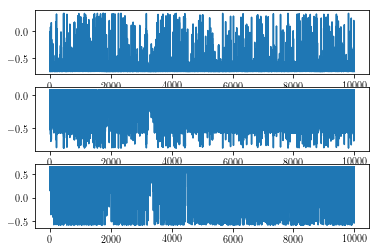

In [12]:
f3 = plt.subplot(3, 1, 1)
plt.plot(xx[:,0])

f3 = plt.subplot(3, 1, 2)
plt.plot(xx[:,1])
f3 = plt.subplot(3, 1, 3)
plt.plot(xx[:,2])

In [17]:
# sel_df = online_df[(online_df['seg_s']>=85500777) &  (online_df['seg_s']<=85548460)]
# datass = sel_df.loc[sel_df['indicator']==3,['p_dup']].values
datas = xx[:5000,0]

exp_state = np.empty(len(online_df), dtype=int)
indicators = online_df['indicator'].values


N = 3 # states
obs_dim = 1

good_length = 1000

num_seqs = int(len(datas)//good_length)

datas_ = datas[:(num_seqs*good_length)]
data = np.reshape(datas_, (num_seqs, good_length, obs_dim))
data = list(data)

In [18]:
len(datass)

10000

In [19]:
################################ MAKE TRAIN AND TEST DATASETS IN BATCHES ##########################


obs_dim = 1

np.random.seed(100)
print('loading data...')
alldata = data
allseqs = np.array(data)
#datas, heldout = hold_out(allseqs,0.05)

datas = list(allseqs[:allseqs.shape[0] - 1, :])
heldout = list(allseqs[-1:, :])

training_size = sum(data.shape[0] for data in datas)
print('...done!')



###################################################  RUN SVI or MF OVER THE TRAINING SET     ########################
init_state_concentration = 1000.
#kappa = 0.
#alpha_0 = 10 #(1)
alpha = 100#200
gamma = 100#200
kappa_sticky = 1
win_size = 1
use_obs_features = False
N = 3#10
infseed = 3

obs_hypparams = {'h_0':np.zeros(obs_dim),
            'J_0':np.ones(obs_dim) * 0.001, #sq_0 #changes the hidden state detection (the lower the better) #0.001
            'alpha_0':np.ones(obs_dim) * 0.1, #(make the number of hidden states worse higher the better)
            'beta_0':np.ones(obs_dim) * 1,
                }
# obs_distns = [distributions.ScalarGaussianNonconjNIG(**obs_hypparams) for state in xrange(N)]
obs_distns = [distributions.GaussianNonconjNIG(**obs_hypparams) for state in range(N)]

HDPHMMSVImodel = models.HMMSegStickyHDP(obs_dim = 1, kappa = 0, alpha=alpha,gamma=gamma,init_state_concentration=init_state_concentration,
        obs_distns=obs_distns, bern_or_weight = 'weight', svi_or_gibbs = 'svi',
        weight_prior_mean = 0, weight_prior_std = 0.1, win_size = win_size,  use_obs_features = use_obs_features)


print('inference observation')
for i in range(N):
    print(obs_distns[i])

print('feature weights before mean field: ', '\n', HDPHMMSVImodel.feature_weights, '\n')


sgd_or_mf = 'sgd' #'mf' or 'sgd' choose between these two

np.random.seed(infseed)
if sgd_or_mf == 'mf':
    print('feature weights before mean field: ', '\n', HDPHMMSVImodel.feature_weights, '\n')
    for i in range(14):
        HDPHMMSVImodel.add_data(datas[i])
    for i in range(20):
        print(HDPHMMSVImodel.meanfield_coordinate_descent_step(0.5))
    print('feature weights after mean field: ', '\n', HDPHMMSVImodel.feature_weights, '\n')
else:
    scores = []
    sgdseq = sgd_passes(tau=0.8,kappa=0.9,datalist=datas, minibatchsize=4,npasses=30) #4, 3
    for t, (data, rho_t) in progprint(enumerate(sgdseq)):
        HDPHMMSVImodel.meanfield_sgdstep(data, np.array(data).shape[0] / np.float(training_size)  , rho_t)
        score = HDPHMMSVImodel.log_likelihood(heldout)
        # print 'feature weights after mean field: ', HDPHMMSVImodel.feature_weights
        print(score)
        print("")
        if t % 1 == 0:
            scores.append(score)
    # plt.plot(scores)
    # plt.show()

loading data...
...done!
inference observation
GaussianNonconjNIG(mu=10.836506,sigmasq=5260.694617)
GaussianNonconjNIG(mu=16.261028,sigmasq=438637245.606165)
GaussianNonconjNIG(mu=8.063854,sigmasq=20921097.579845)
GaussianNonconjNIG(mu=13.761078,sigmasq=7.619078)
GaussianNonconjNIG(mu=-3.301770,sigmasq=7.487363)
GaussianNonconjNIG(mu=-35.364328,sigmasq=28184917139486886854656.000000)
GaussianNonconjNIG(mu=48.749836,sigmasq=6053448177.002948)
GaussianNonconjNIG(mu=29.633141,sigmasq=19.640576)
GaussianNonconjNIG(mu=1.760630,sigmasq=5987664.290612)
GaussianNonconjNIG(mu=25.818543,sigmasq=274109.388953)
feature weights before mean field:  
 [ 0.         -0.01252917 -0.12710608  0.05165648  0.04021663  0.02373538
  0.14436848 -0.2812204  -0.13229498  0.15973507  0.15918885 -0.19499178] 



/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/cnv_detect_final/analysis/pyhsmm/models.py:1121: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  mega_list_z = np.vstack(np.tile(np.diag(np.ones(nhs)),(len(s.data), 1)) for s in mb_states_list)


-2695.679042415727

.-2313.643718498013

.-1768.2010772976544

.-1486.2601189593445

.-1015.3975914579049

.-758.2537178189235

.-349.11242442376647

.-136.2057276682864

.174.34630664341208

.317.0264555733707

.546.6708577271332

.650.2158874416475

.788.9878496405474

.837.1279945056001

.884.3288324884799

.895.3134022043863

.899.6956125910832

.902.6848346115166

.900.3133590000047

.901.1265208565281

.899.4458031818644

.899.4380859319363

.896.6512551338135

.898.4388607571266

.898.430861778454

.  [ 25 done,    3.04sec avg ]
897.7624981285179

.892.837928964997

.897.98015407016

.900.9214964408351

.896.8187714813338

.900.9086437784949

.896.3173258069298

.897.7501226305582

.896.873708790483

.903.9445902440973

.897.4066553987561

.896.550756329347

.900.9261605202947

.905.7806178632608

.903.2060557306238

.906.3808256202192

.904.994352537558

.901.7958711268114

.907.4668861380403

.911.3130760316229

.910.866323875773

.916.1282667253965

.922.0949128477234

.936.3

seq num: 0
used: [2 7 3 5 8]
seq num: 1
used: [7 2 5 3 8]
seq num: 2
used: [2 7 8 3 5]
seq num: 3
used: [7 2 5 3 8]
seq num: 4
used: [7 2 3 5 8]
seq num: 5
used: [2 7 5 8 3]
seq num: 6
used: [2 7 8 5 3]
seq num: 7
used: [2 5 7 8 3]
seq num: 8
used: [7 5 2 3 8]


NameError: name 'true_segments_0_1' is not defined

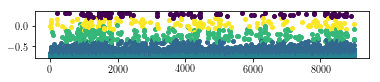

In [22]:
######################################Plotting the states and segments ###########################

f3 = plt.subplot(4, 1, 3)
all_probpairs = []
all_state_seqs = []
all_inferred_segs = []
all_used_states = []
for seq_num in range(num_seqs - 1):
    print('seq num: ' + str(seq_num))
    nhs = N

    #Need this to choose between SVI and mean field
    if sgd_or_mf == 'sgd':
        s_num = -1
        HDPHMMSVImodel.add_data(datas[seq_num], generate=False)
        HDPHMMSVImodel.states_list[s_num].meanfieldupdate()
    else:
        s_num = seq_num

    #States sequence
    states_seq = HDPHMMSVImodel.states_list[s_num].expected_states.argmax(1).astype('int32')
    states_seq = [x if x >= N else x + N for x in states_seq]
    all_state_seqs.extend(states_seq)
    #States usage
    canonical_ids = collections.defaultdict(lambda x=itertools.count(): next(x))

    for state in states_seq:
        canonical_ids[state]
    used_states = list(map(operator.itemgetter(0), sorted(canonical_ids.items(),key=operator.itemgetter(1))))
    print('used:', np.array(used_states) - N)
    all_used_states.extend(used_states)
    segments_seq = []
    for idx, (i, j) in enumerate(zip(HDPHMMSVImodel.states_list[s_num].all_expected_stats[1], HDPHMMSVImodel.states_list[s_num].data)):
        temp_seg = 1- np.argmax((np.sum(i[:nhs]), np.sum(i[nhs:])))
        all_probpairs.append((np.log(np.sum(i[:nhs])), np.log(np.sum(i[nhs:]))))
        segments_seq.append(temp_seg)

    cmap = plt.cm.get_cmap()
    unused_states = [idx for idx in range(N) if idx not in used_states]
    np.random.seed(1)
    colorseq = np.random.RandomState(0).permutation(np.linspace(0,1,N))
    colors = dict((idx, v if False else cmap(v)) for idx, v in zip(np.array(range(N)) + N,colorseq))
    for state in unused_states:
        colors[state] = cmap(1.)

    temp_data = datas[seq_num]
    min_data_point = np.min(temp_data)
    max_data_point = np.max(temp_data)
    #finding the segments
    segment_indices = [i for i, j in enumerate(segments_seq) if j == 1]


    for idx, point in enumerate(temp_data):
        if obs_dim == 1 :
            plt.plot(idx + seq_num * len(temp_data), point, c=colors[states_seq[idx]], marker = '.', markersize=8)
        else:
            plt.plot(idx + seq_num * len(temp_data), states_seq[idx], c=colors[states_seq[idx]], marker = '.', markersize=8)
    current_i = 0
    for i in segment_indices:
        if i - current_i >= 0:
#             print('inf: ', i + seq_num * len(temp_data))
#             plt.axvline(i + seq_num * len(temp_data), color='r') #, linewidth=1
            all_inferred_segs.append(i + seq_num * len(temp_data))
        current_i = i
total_log_prob = 0
for idx, seg in enumerate(true_segments_0_1[:len(all_probpairs)]):
    total_log_prob += all_probpairs[idx][1 - int(seg)]
print('log_prob: ', total_log_prob)
print('used_states: ', len(np.unique(np.array(all_used_states) - N)))
plt.ylabel('Inf. Seg.', fontsize = lablefontsize)

plt.xlim((0,xlim))
plt.subplot(4, 1, 4)
break_prob = [np.exp(i[0]) for i in all_probpairs]
plt.plot(range(len(break_prob)), break_prob, marker = '.')
plt.ylabel('Seg. Prob.', fontsize=lablefontsize)
plt.xlabel('Time', fontsize = lablefontsize)
plt.ylim((0,1))
plt.xlim((0,xlim))
f3.axes.xaxis.set_ticklabels([])
plt.tick_params(axis='x', labelsize=16)
plt.show()

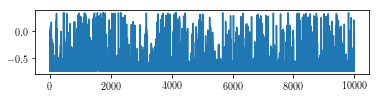

In [21]:
f3 = plt.subplot(3, 1, 1)
plt.plot(xx[:,0])